In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

user_profiles = pd.read_csv('cleaned_user_profiles.csv')
spotify_songs = pd.read_csv('cleaned_spotify_data.csv')

spotify_songs.columns

Index(['track', 'artist', 'genre', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms'],
      dtype='object')

In [2]:
# drop duplicate tracks
spotify_songs = spotify_songs.drop_duplicates(subset='track', keep='first')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Selecting and scaling the features
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'valence', 'tempo']

# Prepare the features for users and songs
user_features = user_profiles[features]
song_features = spotify_songs[features]

# Standardize the features
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features)
song_features_scaled = scaler.transform(song_features)  # Using the same scaler to ensure consistency

from scipy.spatial import distance

# Define a custom distance function
def custom_distance(x, y):
    # Assign high importance to genre match; genres are in index -1 of the dataset
    # Binary value: 0 if genres match, a large number (e.g., 100) if they do not match
    genre_distance = 0 if x[-1] == y[-1] else 100
    
    # Euclidean distance for other features
    feature_distance = distance.euclidean(x[:-1], y[:-1])
    
    # Combine distances
    total_distance = genre_distance + feature_distance
    return total_distance

# We need to include genre as a numeric value in our features for distance calculation
# Map genres to numeric values
genre_mapping = {genre: idx for idx, genre in enumerate(spotify_songs['genre'].unique())}
spotify_songs['genre_numeric'] = spotify_songs['genre'].map(genre_mapping)
user_profiles['genre_numeric'] = user_profiles['genre'].map(genre_mapping)

# Update feature list and data preparation
features_with_genre = features + ['genre_numeric']
song_features_with_genre = spotify_songs[features_with_genre]
user_features_with_genre = user_profiles[features_with_genre]

# Standardize the features (excluding the genre for now)
scaler_with_genre = StandardScaler()
song_features_with_genre_scaled = scaler_with_genre.fit_transform(song_features_with_genre.drop(columns=['genre_numeric']))
user_features_with_genre_scaled = scaler_with_genre.transform(user_features_with_genre.drop(columns=['genre_numeric']))

# Combine scaled features with genre for complete feature set
song_features_complete = np.hstack((song_features_with_genre_scaled, spotify_songs[['genre_numeric']].to_numpy()))
user_features_complete = np.hstack((user_features_with_genre_scaled, user_profiles[['genre_numeric']].to_numpy()))

# Implementing KNN with custom distance
knn_custom = NearestNeighbors(n_neighbors=5, algorithm='auto', metric=custom_distance)
knn_custom.fit(song_features_complete)

def recommend_songs_for_user_by_index(user_index):
    # Check if the user index is valid
    if user_index >= len(user_profiles) or user_index < 0:
        return f"User index {user_index} is out of range."

    # Retrieve user features based on index
    user_data = user_profiles.iloc[[user_index]]
    user_id = user_data['userid'].values[0]  # Extract the user ID
    
    # Extract user features for KNN
    user_features = user_data[features_with_genre].to_numpy()
    user_features_scaled = scaler_with_genre.transform(user_features[:,:-1])
    user_features_complete = np.hstack((user_features_scaled, user_features[:,-1:]))
    
    # Get recommendations
    distances, indices = knn_custom.kneighbors(user_features_complete)
    recommended_songs = spotify_songs.iloc[indices[0]]
    recommended_songs['distance'] = distances[0]
    
    # Get user's top genre
    top_genre = user_data['genre'].values[0]
    
    # Output results
    print(f"User Index: {user_index}")
    print(f"User ID: {user_id}")
    print(f"Top Genre: {top_genre}")
    print("Recommended Songs:")
    display(recommended_songs[['track', 'artist', 'genre', 'distance']])

# Test the function with a sample user index
recommend_songs_for_user_by_index(0)


User Index: 0
User ID: 00055176fea33f6e027cd3302289378b
Top Genre: rock
Recommended Songs:


,track,artist,genre,distance
14886,Vultures,Bokassa,rock,0.647281
15274,Your Light,Scorpions,rock,0.655060
12102,You're My Best Friend - Remastered 2011,Queen,rock,0.663017
13271,Come As You Are,Nirvana,rock,0.663185
14985,In My Dreams (Re-Recorded / Remastered),Dokken,rock,0.671623


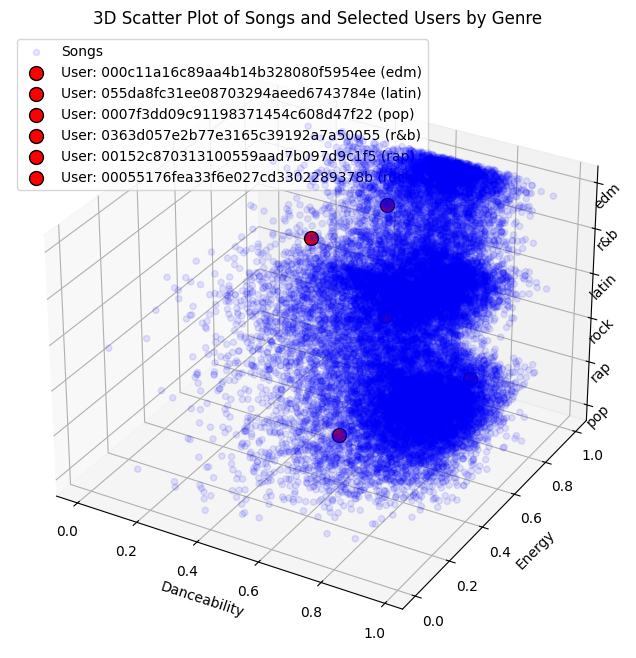

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Map genres to numeric values for plotting
genre_to_numeric = {genre: i for i, genre in enumerate(spotify_songs['genre'].unique())}
spotify_songs['genre_numeric'] = spotify_songs['genre'].map(genre_to_numeric)

# Selecting 6 users with different favorite genres
unique_genres = user_profiles['genre'].unique()[:6]  # Assuming there are at least 6 unique genres
selected_users = user_profiles[user_profiles['genre'].isin(unique_genres)].groupby('genre').first().reset_index()

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for songs
scatter = ax.scatter(spotify_songs['danceability'], spotify_songs['energy'], spotify_songs['genre_numeric'], c='blue', alpha=0.1, label='Songs')

# Scatter plot for selected users
for _, user in selected_users.iterrows():
    ax.scatter(user['danceability'], user['energy'], genre_to_numeric[user['genre']], c='red', edgecolors='black', s=100, label=f"User: {user['userid']} ({user['genre']})")

# Setting labels
ax.set_xlabel('Danceability')
ax.set_ylabel('Energy')
ax.set_zlabel('Genre')

# Setting ticks for genres on the z-axis
ax.set_zticks(list(genre_to_numeric.values()))
ax.set_zticklabels(list(genre_to_numeric.keys()), rotation=45, ha='right')

# Legend and title
ax.legend(loc='upper left')
plt.title('3D Scatter Plot of Songs and Selected Users by Genre')
plt.show()

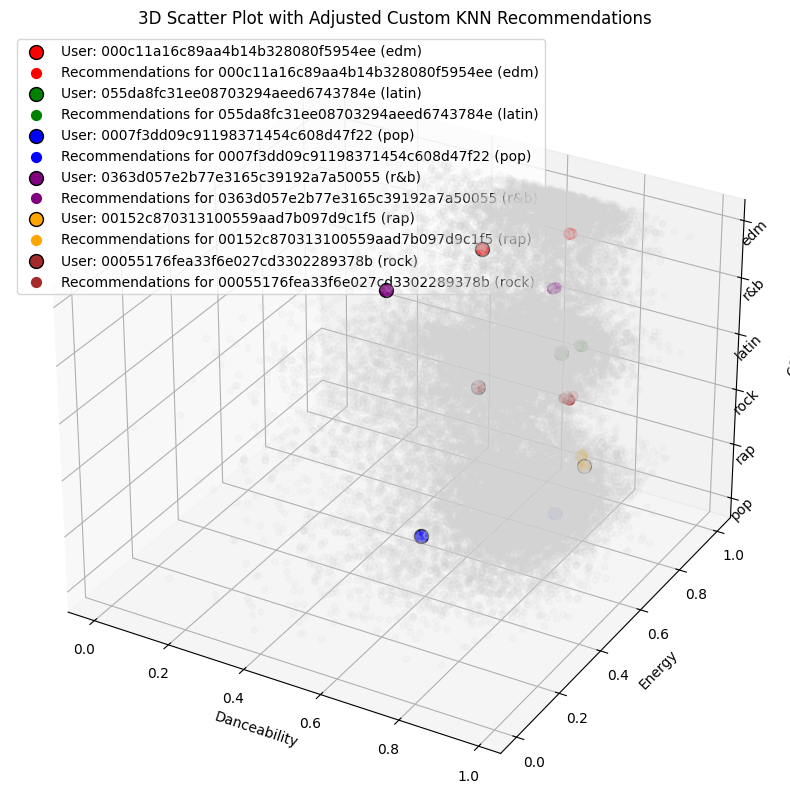

In [5]:
# Adjusting the custom KNN model to work with the correct feature set
knn_custom_adjusted = NearestNeighbors(n_neighbors=5, algorithm='auto', metric=custom_distance)
# Correcting the indices for the features
# Features were danceability (0), energy (1), and genre_numeric was added as the last column
genre_numeric_index = song_features_complete.shape[1] - 1  # Correct index for genre_numeric

# Retrain the custom KNN model with the correct indices for danceability, energy, and genre_numeric
knn_custom_adjusted.fit(song_features_complete[:, [0, 1, genre_numeric_index]])

# Adjusted function to recommend songs and plot
def get_custom_adjusted_recommendations_and_plot(user_row):
    # Extract user features including the numeric genre
    user_features = np.array([[user_row['danceability'], user_row['energy'], genre_to_numeric[user_row['genre']]]])
    
    # Get recommendations using the adjusted custom KNN model with genre-sensitive distance
    distances, indices = knn_custom_adjusted.kneighbors(user_features)
    return spotify_songs.iloc[indices[0]]

# Plotting with adjusted custom KNN recommendations
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']

# Scatter plot for songs (light grey for background)
ax.scatter(spotify_songs['danceability'], spotify_songs['energy'], spotify_songs['genre_numeric'], c='lightgrey', alpha=0.1)

# Plot each user and their recommended songs using the adjusted custom KNN model
for idx, (color, (_, user)) in enumerate(zip(colors, selected_users.iterrows())):
    # Plot user
    ax.scatter(user['danceability'], user['energy'], genre_to_numeric[user['genre']], c=color, edgecolors='black', s=100, label=f"User: {user['userid']} ({user['genre']})")
    
    # Get and plot adjusted custom KNN recommendations
    recommended_songs_custom_adjusted = get_custom_adjusted_recommendations_and_plot(user)
    ax.scatter(recommended_songs_custom_adjusted['danceability'], recommended_songs_custom_adjusted['energy'], recommended_songs_custom_adjusted['genre_numeric'], c=color, label=f"Recommendations for {user['userid']} ({user['genre']})", s=50)

# Setting labels and legend
ax.set_xlabel('Danceability')
ax.set_ylabel('Energy')
ax.set_zlabel('Genre')
ax.set_zticks(list(genre_to_numeric.values()))
ax.set_zticklabels(list(genre_to_numeric.keys()), rotation=45, ha='right')
ax.legend(loc='upper left')
plt.title('3D Scatter Plot with Adjusted Custom KNN Recommendations')
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Features and additional genre column to be considered
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'valence', 'tempo', 'genre_numeric']
features_with_genre = features + ['genre_numeric']

# Initialize the scaler for genre
scaler_with_genre = StandardScaler()
scaler_with_genre.fit(spotify_songs[features[:-1]])
# Select 6 users with unique favorite genres
unique_genres_users = user_profiles.drop_duplicates(subset=['genre']).sample(n=1)

# Collect user recommendations
all_recs = []
for index, user in unique_genres_users.iterrows():
    user_features = user[features].to_numpy().reshape(1, -1)
    user_features_scaled = scaler_with_genre.transform(user_features[:, :-1])
    user_features_complete = np.hstack((user_features_scaled, user_features[:, -1:]))

    # Get recommendations
    _, indices = knn_custom.kneighbors(user_features_complete)
    recommended_songs = spotify_songs.iloc[indices[0]].copy()
    recommended_songs['user_id'] = user['userid']  # Ensure user_id is included
    recommended_songs['Type'] = 'Recommendation'
    
    # Append recommendations
    all_recs.append(recommended_songs)

    # Prepare and append user data with the same structure
    user_for_plot = pd.DataFrame(user[features].values.reshape(1, -1), columns=features)
    user_for_plot['user_id'] = user['userid']
    user_for_plot['Type'] = 'User'
    all_recs.append(user_for_plot)



In [7]:
# Combine all recommendations and user data into a single DataFrame
combined_data = pd.concat(all_recs, ignore_index=True)


In [9]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Assuming 'combined_data' is your DataFrame including the 'Type' column with 'User' and 'Recommendation'
# Normalize features excluding the 'Type' which is categorical
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'genre_numeric']
scaler = StandardScaler()
combined_data[features] = scaler.fit_transform(combined_data[features])

# Convert 'Type' to numeric codes for color mapping
type_color_mapping = {'User': 1, 'Recommendation': 2}
combined_data['Color'] = combined_data['Type'].map(type_color_mapping)

# Define colorscale
colorscale = [[0, 'red'], [1, 'midnightblue']]

# Create parallel coordinates plot
fig = px.parallel_coordinates(combined_data, 
                              dimensions=features, 
                              color='Color',
                              labels={col: col.capitalize() for col in features},
                              color_continuous_scale=colorscale)

fig.show()
